# Análisis de Equidad y Explicabilidad en Clasificación Multiclase
## Diagnóstico de Patologías Valvulares Cardíacas con CatBoost


### Objetivo del Notebook

Este notebook implementa un análisis comparativo de **tres modelos** con diferentes estrategias de mitigación de sesgo, evaluados mediante técnicas de **Explicabilidad (XAI)**:

**Modelos comparados:**
1. **Modelo Base** - Original con `race_ethnicity_encoded`
2. **Modelo Blind** - Sin variable sensible (exclusión)
3. **Modelo Weighted** - Con pesos de equidad que penalizan grupos con alto FNR

**Técnicas XAI aplicadas:**
- **SHAP** - Importancia global y explicaciones locales
- **LIME** - Explicaciones locales interpretables
- **DiCE** - Contrafactuales (qué cambiar para alterar predicción)

**Casos de estudio específicos:**
- **Índice 1000** - True Positive identificado en análisis original
- **Índice 48** - False Negative identificado en análisis original

---

## Configuración del entorno

En esta sección prentendo dejar el entorno configurado para trabajar posteriormente.

In [1]:
# Instalación de dependencias
# !pip install fairlearn catboost shap lime dice-ml pandas numpy matplotlib seaborn scikit-learn joblib

In [2]:
# Bibliotecas estándar
import os
import json
import glob
import warnings
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, f1_score, accuracy_score

from sklearn.utils.class_weight import compute_sample_weight
from catboost import CatBoostClassifier, Pool

# Fairlearn - Métricas de equidad [2]
from fairlearn.metrics import MetricFrame

# XAI
import shap
import lime
import lime.lime_tabular
import dice_ml

In [3]:
# Realizo configuraciones globales
warnings.filterwarnings('ignore')

In [4]:
# Hago configuraciones globales para los gráficos
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

Defino variables globales.

In [5]:
# Configuro la semilla para reproducibilidad, requisito fundamental según TRIPOD-AI (ítem 14) [TRIPOD] y el AI Act [AI Act] para sistemas de alto riesgo
RANDOM_STATE = 1976

# Defino las rutas a los ficheros
# Configuro la ruta de los datos.
DRIVE_PATH = 'D:\\Desarrollo\\TFG\\Procesado\\' # Local
# DRIVE_PATH = '/content/drive/MyDrive/Colab Notebooks/TFG/Dataset/Procesado/' # Google Drive

# Configuro las rutas para guardar modelos y resultados
MODELS_PATH = os.path.join(DRIVE_PATH, 'modelos')
RESULTS_PATH = os.path.join(DRIVE_PATH, 'resultados')
FIGURES_PATH = os.path.join(DRIVE_PATH, 'figuras')
XAI_PATH = os.path.join(RESULTS_PATH, 'xai')

for path in [MODELS_PATH, RESULTS_PATH, FIGURES_PATH, XAI_PATH]:
    os.makedirs(path, exist_ok=True)

# Defino los ficheros de datos
X_TRAIN_FILE = os.path.join(DRIVE_PATH, 'X_train_selected.csv')
X_VAL_FILE = os.path.join(DRIVE_PATH, 'X_val_selected.csv')
X_TEST_FILE = os.path.join(DRIVE_PATH, 'X_test_selected.csv')
Y_TRAIN_FILE = os.path.join(DRIVE_PATH, 'y_train.csv')
Y_VAL_FILE = os.path.join(DRIVE_PATH, 'y_val.csv')
Y_TEST_FILE = os.path.join(DRIVE_PATH, 'y_test.csv')
ENCODERS_FILE = os.path.join(DRIVE_PATH, 'encoders_mapping.json')

Creo una función para mostrar logs

In [6]:
def log(mensaje):
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{timestamp}] {mensaje}")

Defino variables globales.

### Carga de datos y modelo

Modelo 1. Se cargan desde disco el modelo base para trabajar con él.

In [7]:
# Cargo los datos
X_train = pd.read_csv(X_TRAIN_FILE)
X_val = pd.read_csv(X_VAL_FILE)
X_test = pd.read_csv(X_TEST_FILE)
y_train = pd.read_csv(Y_TRAIN_FILE).squeeze()
y_val = pd.read_csv(Y_VAL_FILE).squeeze()
y_test = pd.read_csv(Y_TEST_FILE).squeeze()

with open(ENCODERS_FILE, 'r', encoding='utf-8') as f:
    data = json.load(f)
CLASS_NAMES = {int(k): v for k, v in data['cardiopatia'].items()
                if v != 'No se puede determinar'}
RACE_ETHNICITY = {int(k): v for k, v in data['race_ethnicity'].items()}

TARGET_LABEL_NAME = "Estenosis"
TARGET_CLASS_IDX = next(k for k, v in CLASS_NAMES.items() if v == TARGET_LABEL_NAME)
TARGET_SAFE_CLASS_NAME = 'Ninguna'
SAFE_CLASS_IDX = next(k for k, v in CLASS_NAMES.items() if v == TARGET_SAFE_CLASS_NAME)

# Defino constantes globales
N_CLASSES = len(CLASS_NAMES)
FEATURE_NAMES = X_train.columns.tolist()

# Defino las variables categóricas, aunque sean codificadas como números
CATEGORICAL_FEATURES = ['sex_encoded', 'race_ethnicity_encoded']
CATEGORICAL_INDEXES = [FEATURE_NAMES.index(col) for col in CATEGORICAL_FEATURES if col in FEATURE_NAMES]
SENSITIVE_FEATURE = 'race_ethnicity_encoded'

In [8]:
# Cargo el modelo final
SELECTED_MODEL = 'catboost'
FINAL_MODEL_PATH = os.path.join(MODELS_PATH, f'{SELECTED_MODEL}_*.joblib')
model_files = glob.glob(os.path.join(MODELS_PATH, f'{SELECTED_MODEL}_*.joblib'))
if not model_files:
    raise FileNotFoundError(f"No se encontró el modelo final {FINAL_MODEL_PATH}.")

model_files.sort(reverse=True)
model_file = model_files[0]
meta_file = model_file.replace('.joblib', '_meta.json')

FINAL_MODEL = joblib.load(model_file)

print(f'MODELO PARA ANÁLISIS XAI')
print(f'Tipo: {type(FINAL_MODEL).__name__}')
print(f'Features: {len(FEATURE_NAMES)}')
print(f'Clases: {N_CLASSES} ({", ".join(CLASS_NAMES.values())})')

# Hago un precálculo de las predicciones
y_pred_base = FINAL_MODEL.predict(X_val).flatten()
y_pred_proba_base = FINAL_MODEL.predict_proba(X_val)
accuracy_base = accuracy_score(y_val, y_pred_base)

MODELO PARA ANÁLISIS XAI
Tipo: CatBoostClassifier
Features: 48
Clases: 4 (Ambas, Estenosis, Insuficiencia, Ninguna)


## Creación de Modelos Mitigados

### Modelo 2: Blind (sin variable sensible)
Estrategia: Excluir `race_ethnicity_encoded` del entrenamiento [3]

### Modelo 3: Weighted (pesos de equidad)
Estrategia: Penalizar grupos con alto FNR histórico [7]

In [9]:
# MODELO 2: BLIND (SIN VARIABLE SENSIBLE)
# Estrategia "Fairness through unawareness" [3]
# Excluye race_ethnicity_encoded del conjunto de features.

# Calculo las características sin la variable sensible
features_blind = [f for f in FEATURE_NAMES if f != SENSITIVE_FEATURE]
categorical_blind = [c for c in CATEGORICAL_FEATURES if c != SENSITIVE_FEATURE]

X_train_blind = X_train[features_blind].copy()
X_val_blind = X_val[features_blind].copy()

print(f"Features: {len(features_blind)} (excluida: {SENSITIVE_FEATURE})")

# Entreno el modelo blind
cat_model_blind = CatBoostClassifier(
    iterations=1000, # Aumentado para compensar la pérdida de información
    depth=6,
    learning_rate=0.05, # Reducido para mejorar la convergencia
    loss_function='MultiClass',
    cat_features=categorical_blind,
    random_seed=RANDOM_STATE,
    verbose=False,
    allow_writing_files=False
    ,task_type='GPU' # Lo incluyo para usar la GPU
)

cat_model_blind.fit(
    X_train_blind, y_train,
    eval_set=(X_val_blind, y_val),
    plot=False
)

# Predicciones
y_pred_blind = cat_model_blind.predict(X_val_blind).flatten()
y_pred_proba_blind = cat_model_blind.predict_proba(X_val_blind)
accuracy_blind = accuracy_score(y_val, y_pred_blind)

print(f'MODELO BLIND')
print(f"- Accuracy: {accuracy_blind:.4f} (Base: {accuracy_base:.4f}, Variación: {accuracy_blind-accuracy_base:+.4f})")

Features: 47 (excluida: race_ethnicity_encoded)
MODELO BLIND
- Accuracy: 0.6035 (Base: 0.4262, Variación: +0.1773)


In [10]:
# MODELO 3: WEIGHTED (PESOS DE EQUIDAD)
# Estrategia: Penalizar grupos étnico-clase con alto FNR histórico [7]
# Mantiene race_ethnicity_encoded pero ajusta pesos de entrenamiento.

# Creo una función para calcular los pesos de equidad
def fairness_weight_calculation(X, y, sensitive_col, target_fnr=0.2):
    # Calcula pesos que penalizan grupos con alto FNR histórico.
    
    # La idea es que si un grupo étnico tiene FNR alto para una clase,
    # aumentamos el peso de esas muestras para que el modelo aprenda
    # mejor a detectar esos casos [7].
    
    # Parámetros:
    # -----------
    # X : DataFrame - Features de entrenamiento
    # y : Series - Variable objetivo
    # sensitive_col : str - Nombre de la variable sensible
    # target_fnr : float - FNR objetivo (umbral para penalización)
    
    # Retorna:
    # --------
    # np.array : Pesos para cada muestra
    
    # Entreno eñ modelo preliminar para estimar FNR por grupo
    model_prelim = CatBoostClassifier(
        iterations=200,
        depth=4,
        random_seed=RANDOM_STATE,
        verbose=False,
        allow_writing_files=False
        ,task_type='GPU' # Lo incluyo para usar la GPU
    )
    model_prelim.fit(X, y, cat_features=CATEGORICAL_FEATURES)
    y_pred_prelim = model_prelim.predict(X).flatten()
  
    # Inicializo los pesos
    weight = np.ones(len(y))
    
    # Calculo FNR por grupo étnico y clase
    for group in X[sensitive_col].unique():
        mask_group = X[sensitive_col] == group
        group_name = RACE_ETHNICITY.get(group, f'Grupo_{group}')
        
        for class_id in y.unique():
            mask_class = y == class_id
            mask = mask_group & mask_class
            
            if mask.sum() == 0:
                continue
            
            # Calculo FNR para este grupo-clase
            y_true_gc = y[mask]
            y_pred_gc = y_pred_prelim[mask]
            
            tp = ((y_true_gc == class_id) & (y_pred_gc == class_id)).sum()
            fn = ((y_true_gc == class_id) & (y_pred_gc != class_id)).sum()
            
            fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
            
            # Aumento el peso si FNR supera el objetivo
            if fnr > target_fnr:
                factor = 1 + (fnr - target_fnr) * 3  # Factor de ajuste
                weight[mask] *= factor
                print(f"{group_name} x {CLASS_NAMES.get(class_id, class_id)}: FNR={fnr:.2%} → peso x{factor:.2f}")
    
    # Normalizo los pesos para que sumen len(y)
    weight = weight * len(y) / weight.sum()
    
    return weight

# Calculo los pesos de equidad
fairness_weight = fairness_weight_calculation(
    X_train, y_train, 
    sensitive_col=SENSITIVE_FEATURE,
    target_fnr=0.2
)

# Entreno el modelo weighted
cat_model_weighted = CatBoostClassifier(
    iterations=1000, # Aumentado para compensar la pérdida de información
    depth=6,
    learning_rate=0.05, # Reducido para mejorar la convergencia
    loss_function='MultiClass',
    cat_features=CATEGORICAL_FEATURES,
    random_seed=RANDOM_STATE,
    verbose=False,
    allow_writing_files=False
    ,task_type='GPU' # Lo incluyo para usar la GPU
)

cat_model_weighted.fit(
    X_train, y_train,
    sample_weight=fairness_weight,
    eval_set=(X_val, y_val),
    plot=False
)

# Predicciones
y_pred_weighted = cat_model_weighted.predict(X_val).flatten()
y_pred_proba_weighted = cat_model_weighted.predict_proba(X_val)
accuracy_weighted = accuracy_score(y_val, y_pred_weighted)

print(f"MODELO WEIGHTED")
print(f"- Accuracy: {accuracy_weighted:.4f} (Base: {accuracy_base:.4f}, Variación: {accuracy_weighted-accuracy_base:+.4f})")

other x Ninguna: FNR=78.56% → peso x2.76
other x Ambas: FNR=75.79% → peso x2.67
other x Estenosis: FNR=100.00% → peso x3.40
white x Ninguna: FNR=85.44% → peso x2.96
white x Ambas: FNR=72.87% → peso x2.59
white x Estenosis: FNR=99.74% → peso x3.39
hispanic x Ninguna: FNR=82.70% → peso x2.88
hispanic x Ambas: FNR=85.42% → peso x2.96
hispanic x Estenosis: FNR=95.68% → peso x3.27
black x Ninguna: FNR=80.85% → peso x2.83
black x Ambas: FNR=90.53% → peso x3.12
black x Estenosis: FNR=100.00% → peso x3.40
asian x Ninguna: FNR=81.58% → peso x2.85
asian x Ambas: FNR=84.51% → peso x2.94
asian x Estenosis: FNR=100.00% → peso x3.40
unknown x Ninguna: FNR=79.46% → peso x2.78
unknown x Ambas: FNR=79.03% → peso x2.77
unknown x Estenosis: FNR=100.00% → peso x3.40
MODELO WEIGHTED
- Accuracy: 0.5095 (Base: 0.4262, Variación: +0.0833)


In [11]:
# RESUMEN DE MODELOS

print("RESUMEN: TRES MODELOS PARA LA COMPARACIÓN")

models_info = pd.DataFrame({
    'Modelo': ['Base', 'Blind', 'Weighted'],
    'Estrategia': [
        'Original (con race_ethnicity)',
        'Sin variable sensible',
        'Pesos de equidad por FNR'
    ],
    'N_Features': [len(FEATURE_NAMES), len(features_blind), len(FEATURE_NAMES)],
    'Usa_Race': ['Sí', 'No', 'Sí'],
    'Accuracy': [accuracy_base, accuracy_blind, accuracy_weighted]
})

print(models_info.to_string(index=False))

# Creo un diccionario para tener un acceso más fácil
MODELS = {
    'Base': {
        'model': FINAL_MODEL,
        'X_val': X_val,
        'y_pred': y_pred_base,
        'features': FEATURE_NAMES,
        'accuracy': accuracy_base
    },
    'Blind': {
        'model': cat_model_blind,
        'X_val': X_val_blind,
        'y_pred': y_pred_blind,
        'features': features_blind,
        'accuracy': accuracy_blind
    },
    'Weighted': {
        'model': cat_model_weighted,
        'X_val': X_val,
        'y_pred': y_pred_weighted,
        'features': FEATURE_NAMES,
        'accuracy': accuracy_weighted
    }
}

RESUMEN: TRES MODELOS PARA LA COMPARACIÓN
  Modelo                    Estrategia  N_Features Usa_Race  Accuracy
    Base Original (con race_ethnicity)          48       Sí  0.426206
   Blind         Sin variable sensible          47       No  0.603507
Weighted      Pesos de equidad por FNR          48       Sí  0.509498


## Métricas de Equidad: Comparativa de FNR por Grupo

In [12]:
# Creo una función para calcular FNR por grupo étnico y clase
def fnr_group_multiclass(y_true, y_pred, sensitive_feature, class_names, race_map):
    """
    Calcula la Tasa de Falsos Negativos (FNR) por grupo étnico para cada clase.
    FNR = FN / (FN + TP) = 1 - Recall
    """
    results = []
    
    for group in np.unique(sensitive_feature):
        mask = sensitive_feature == group
        y_true_g = y_true[mask]
        y_pred_g = y_pred[mask]
        
        for class_id, class_name in class_names.items():
            trues = y_true_g == class_id
            preds = y_pred_g == class_id
            
            tp = (trues & preds).sum()
            fn = (trues & ~preds).sum()
            
            fnr = fn / (fn + tp) if (fn + tp) > 0 else np.nan
            
            results.append({
                'Grupo': race_map.get(group, f'Grupo_{group}'),
                'Clase': class_name,
                'FNR': fnr,
                'N_reales': trues.sum()
            })
    
    return pd.DataFrame(results)

In [13]:
# Realizo el cálculo de FNR para los tres modelos

sensitive_vals = X_val[SENSITIVE_FEATURE].values

fnr_results = {}

for name, info in MODELS.items():
    df_fnr = fnr_group_multiclass(
        y_val.values,
        info['y_pred'],
        sensitive_vals,
        CLASS_NAMES,
        RACE_ETHNICITY
    )
    fnr_results[name] = df_fnr
    
    # Tabla pivote
    pivot = df_fnr.pivot(index='Grupo', columns='Clase', values='FNR')
    print(f"Modelo {name}")
    print(pivot.round(3).to_string())
    
    # Disparidad máxima por clase
    print(f"Disparidad máxima (max - min) por clase:")
    for class_id in CLASS_NAMES.values():
        fnr_class = df_fnr[df_fnr['Clase'] == class_id]['FNR'].dropna()
        if len(fnr_class) > 1:
            disparidad = fnr_class.max() - fnr_class.min()
            print(f"{class_id}: {disparidad:.1%}")

Modelo Base
Clase     Ambas  Estenosis  Insuficiencia  Ninguna
Grupo                                             
asian     0.167      1.000          0.622    0.583
black     0.581      1.000          0.594    0.346
hispanic  0.484      0.923          0.652    0.384
other     0.317      1.000          0.681    0.417
unknown   0.432      0.929          0.640    0.418
white     0.371      0.842          0.740    0.437
Disparidad máxima (max - min) por clase:
Ambas: 41.4%
Estenosis: 15.8%
Insuficiencia: 14.6%
Ninguna: 23.8%
Modelo Blind
Clase     Ambas  Estenosis  Insuficiencia  Ninguna
Grupo                                             
asian     0.917        1.0          0.000    1.000
black     1.000        1.0          0.041    0.951
hispanic  0.969        1.0          0.019    0.973
other     0.780        1.0          0.043    0.972
unknown   0.795        1.0          0.023    0.945
white     0.894        1.0          0.021    0.968
Disparidad máxima (max - min) por clase:
Ambas: 22.0

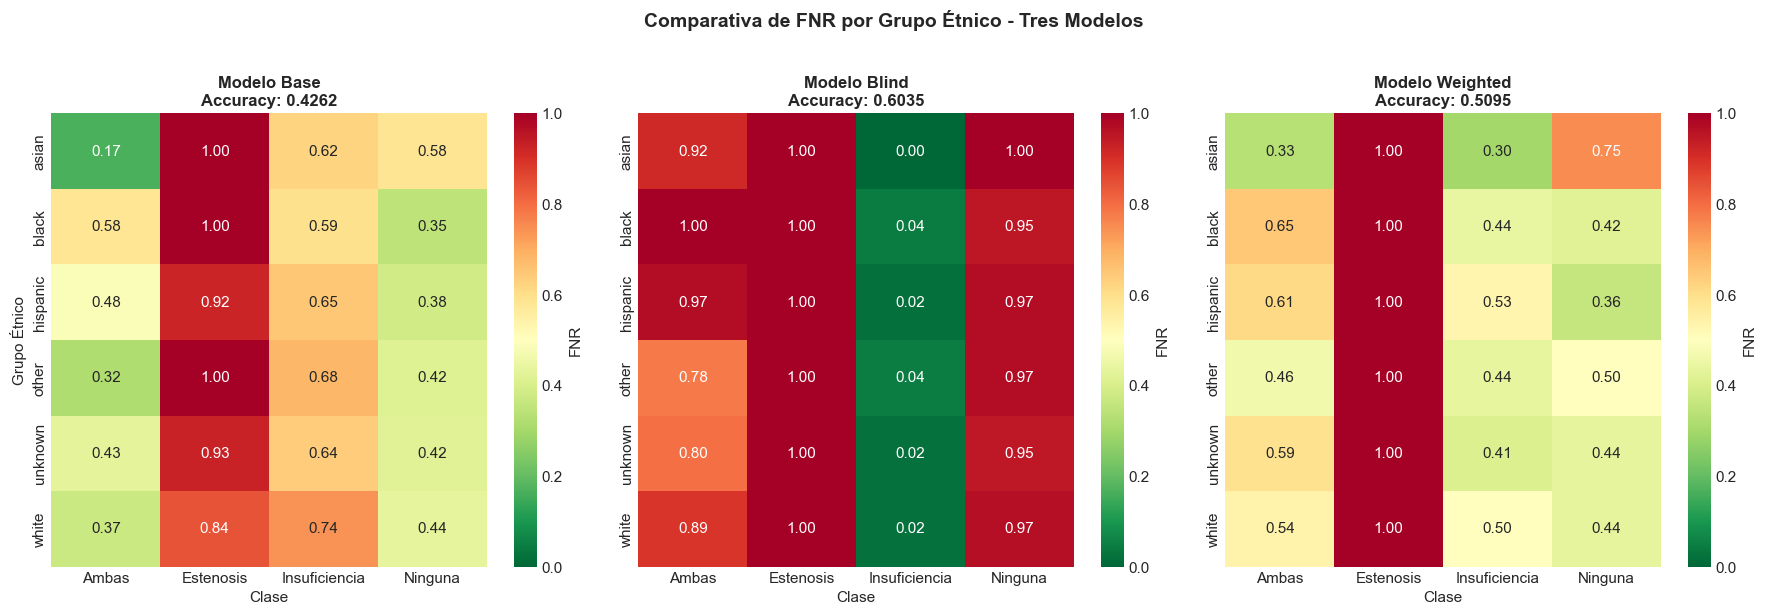

In [14]:
# Realizo la visualización comparativa de FNR para los tres modelos

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (name, df_fnr) in enumerate(fnr_results.items()):
    pivot = df_fnr.pivot(index='Grupo', columns='Clase', values='FNR')
    
    sns.heatmap(pivot, annot=True, fmt='.2f', cmap='RdYlGn_r',
                vmin=0, vmax=1, ax=axes[idx],
                cbar_kws={'label': 'FNR'})
    axes[idx].set_title(f'Modelo {name}\nAccuracy: {MODELS[name]["accuracy"]:.4f}', 
                        fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Clase')
    axes[idx].set_ylabel('Grupo Étnico' if idx == 0 else '')

plt.suptitle('Comparativa de FNR por Grupo Étnico - Tres Modelos', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()
plt.close()

In [15]:
# Creo una tabla resumen de disparidades
print("RESUMEN: DISPARIDAD MÁXIMA EN FNR POR MODELO Y CLASE")

disparity_summary = []

for class_id in CLASS_NAMES.values():
    row = {'Clase': class_id}
    for name, df_fnr in fnr_results.items():
        fnr_class = df_fnr[df_fnr['Clase'] == class_id]['FNR'].dropna()
        disparity = fnr_class.max() - fnr_class.min() if len(fnr_class) > 1 else 0
        row[f'Disp_{name}'] = disparity
    disparity_summary.append(row)

df_disparity_summary = pd.DataFrame(disparity_summary)

# Calculo la mejora respecto al modelo base
df_disparity_summary['Mejora_Blind'] = df_disparity_summary['Disp_Base'] - df_disparity_summary['Disp_Blind']
df_disparity_summary['Mejora_Weighted'] = df_disparity_summary['Disp_Base'] - df_disparity_summary['Disp_Weighted']

print(df_disparity_summary.round(3).to_string(index=False))

# Guardo la tabla resumen
df_disparity_summary.to_csv('resumen_disparidades_3modelos.csv', index=False)

RESUMEN: DISPARIDAD MÁXIMA EN FNR POR MODELO Y CLASE
        Clase  Disp_Base  Disp_Blind  Disp_Weighted  Mejora_Blind  Mejora_Weighted
        Ambas      0.414       0.220          0.312         0.194            0.102
    Estenosis      0.158       0.000          0.000         0.158            0.158
Insuficiencia      0.146       0.043          0.238         0.103           -0.092
      Ninguna      0.238       0.055          0.387         0.183           -0.149


## Análisis de Casos Específicos: TP (idx=1000) y FN (idx=48)

Estos casos fueron identificados en el análisis XAI original como ejemplos representativos de acierto (TP) y error crítico (FN).

In [16]:
# Defino los casos de estudio detectados en el análisis original===============

IDX_TP = 1000  # True Positive en el análisis original
IDX_FN = 48    # False Negative en el análisis original

STUDY_CASES = {
    'TP Original (idx=1000)': IDX_TP,
    'FN Original (idx=48)': IDX_FN
}

In [17]:
# Realizo el análisis comparativo de predicciones para los casos específicos
cases_results = []

for case_name, idx in STUDY_CASES.items():
    print(f"CASO: {case_name}")
    
    # Obtengo la información de la persona paciente
    patient = X_val.iloc[idx]
    y_real = y_val.iloc[idx]
    race_ethnicity_group = RACE_ETHNICITY.get(int(patient[SENSITIVE_FEATURE]), 'Desconocido')
    
    print(f"Información del paciente:")
    print(f"Índice: {idx}")
    print(f"Grupo étnico: {race_ethnicity_group}")
    print(f"Diagnóstico real: {CLASS_NAMES[y_real]} (clase {y_real})")
    
    print(f"Predicciones por modelo:")
    
    for model_name, info in MODELS.items():
        X_case = info['X_val'].iloc[[idx]]
        pred = info['model'].predict(X_case)[0]
        if hasattr(pred, 'item'):
            pred = pred.item()
        elif isinstance(pred, np.ndarray):
            pred = int(pred.flatten()[0])
        proba = info['model'].predict_proba(X_case)[0]
        
        is_correct = (pred == y_real)
        result = 'Correcto' if is_correct else 'Incorrecto'
        
        print(f"{model_name:10}: {CLASS_NAMES[pred]:15} (prob: {proba[pred]:.3f}) {result}")
        
        cases_results.append({
            'Caso': case_name,
            'Índice': idx,
            'Grupo_Étnico': race_ethnicity_group,
            'Y_Real': CLASS_NAMES[y_real],
            'Modelo': model_name,
            'Predicción': CLASS_NAMES[pred],
            'Probabilidad': proba[pred],
            'Correcto': is_correct
        })

df_cases = pd.DataFrame(cases_results)

# Nuestro el resumen de predicciones por caso y modelo
print("RESUMEN DE PREDICCIONES POR CASO Y MODELO")

pivot_cases = df_cases.pivot(index='Caso', columns='Modelo', values='Correcto')
print(pivot_cases.to_string())

df_cases.to_csv('analisis_casos_especificos.csv', index=False)

CASO: TP Original (idx=1000)
Información del paciente:
Índice: 1000
Grupo étnico: white
Diagnóstico real: Estenosis (clase 1)
Predicciones por modelo:
Base      : Estenosis       (prob: 0.567) Correcto
Blind     : Insuficiencia   (prob: 0.599) Incorrecto
Weighted  : Ninguna         (prob: 0.441) Incorrecto
CASO: FN Original (idx=48)
Información del paciente:
Índice: 48
Grupo étnico: hispanic
Diagnóstico real: Estenosis (clase 1)
Predicciones por modelo:
Base      : Ninguna         (prob: 0.471) Incorrecto
Blind     : Insuficiencia   (prob: 0.598) Incorrecto
Weighted  : Ninguna         (prob: 0.535) Incorrecto
RESUMEN DE PREDICCIONES POR CASO Y MODELO
Modelo                   Base  Blind  Weighted
Caso                                          
FN Original (idx=48)    False  False     False
TP Original (idx=1000)   True  False     False


## XAI: Análisis SHAP Comparativo

In [18]:
# Calculo de SHAP values usando el método nativo de CatBoost
print("SHAP: CALCULANDO VALORES CON MÉTODO NATIVO DE CATBOOST")


shap_values_dict = {}
shap_importance_dict = {}

for name, info in MODELS.items():
    print(f"Calculando SHAP para modelo {name}...")
    
    if name == 'Blind':
        pool = Pool(info['X_val'], cat_features=categorical_blind)
    else:
        pool = Pool(info['X_val'], cat_features=CATEGORICAL_FEATURES)
    
    n_features = len(info['features'])
    
    # Calculo SHAP values con método el nativo para evitar el error de kernel SHAP
    shap_raw = info['model'].get_feature_importance(
        data=pool,
        type='ShapValues'
    )
    
    # Shape real: (n_samples, n_classes, n_features + 1)
    # La última columna de cada clase es el base value
    print(f"Shape raw: {shap_raw.shape}")
    
    # Quito el base value (última columna de la dimensión de features)
    # Shape: (n_samples, n_classes, n_features)
    shap_vals = shap_raw[:, :, :-1]
    
    # Transpongo a (n_samples, n_features, n_classes) para dar consistencia
    shap_vals = np.transpose(shap_vals, (0, 2, 1))
    
    shap_values_dict[name] = shap_vals
    
    # Calculo la importancia por característica: promedio de |SHAP| sobre muestras y clases
    feature_importance = np.abs(shap_vals).mean(axis=(0, 2))
    shap_importance_dict[name] = feature_importance
    
    print(f"Shape final: {shap_vals.shape} (n_samples, n_features, n_classes)")
    print(f" Importancia shape: {feature_importance.shape}")

SHAP: CALCULANDO VALORES CON MÉTODO NATIVO DE CATBOOST
Calculando SHAP para modelo Base...


Shape raw: (2053, 4, 49)
Shape final: (2053, 48, 4) (n_samples, n_features, n_classes)
 Importancia shape: (48,)
Calculando SHAP para modelo Blind...
Shape raw: (2053, 4, 48)
Shape final: (2053, 47, 4) (n_samples, n_features, n_classes)
 Importancia shape: (47,)
Calculando SHAP para modelo Weighted...
Shape raw: (2053, 4, 49)
Shape final: (2053, 48, 4) (n_samples, n_features, n_classes)
 Importancia shape: (48,)


In [19]:
# Calculo e imprimo la importancia de la variable sensible
print("SHAP: IMPORTANCIA DE race_ethnicity_encoded")

for name in ['Base', 'Weighted']:
    features = MODELS[name]['features']
    feature_importance = shap_importance_dict[name]
    
    idx_race = features.index(SENSITIVE_FEATURE)
    importancia_race = feature_importance[idx_race]
    
    # Ranking (1 = la más importante)
    ranking = len(features) - np.argsort(np.argsort(feature_importance))[idx_race]
    
    print(f"{name}:")
    print(f"Importancia SHAP de {SENSITIVE_FEATURE}: {importancia_race:.4f}")
    print(f"Ranking: #{ranking} de {len(features)}")

print(f"Blind:")
print(f"{SENSITIVE_FEATURE}: N/A (variable excluida del modelo)")

SHAP: IMPORTANCIA DE race_ethnicity_encoded
Base:
Importancia SHAP de race_ethnicity_encoded: 0.0939
Ranking: #3 de 48
Weighted:
Importancia SHAP de race_ethnicity_encoded: 0.0864
Ranking: #4 de 48
Blind:
race_ethnicity_encoded: N/A (variable excluida del modelo)


Base: 48 features, importance: 48 valores
Blind: 47 features, importance: 47 valores
Weighted: 48 features, importance: 48 valores


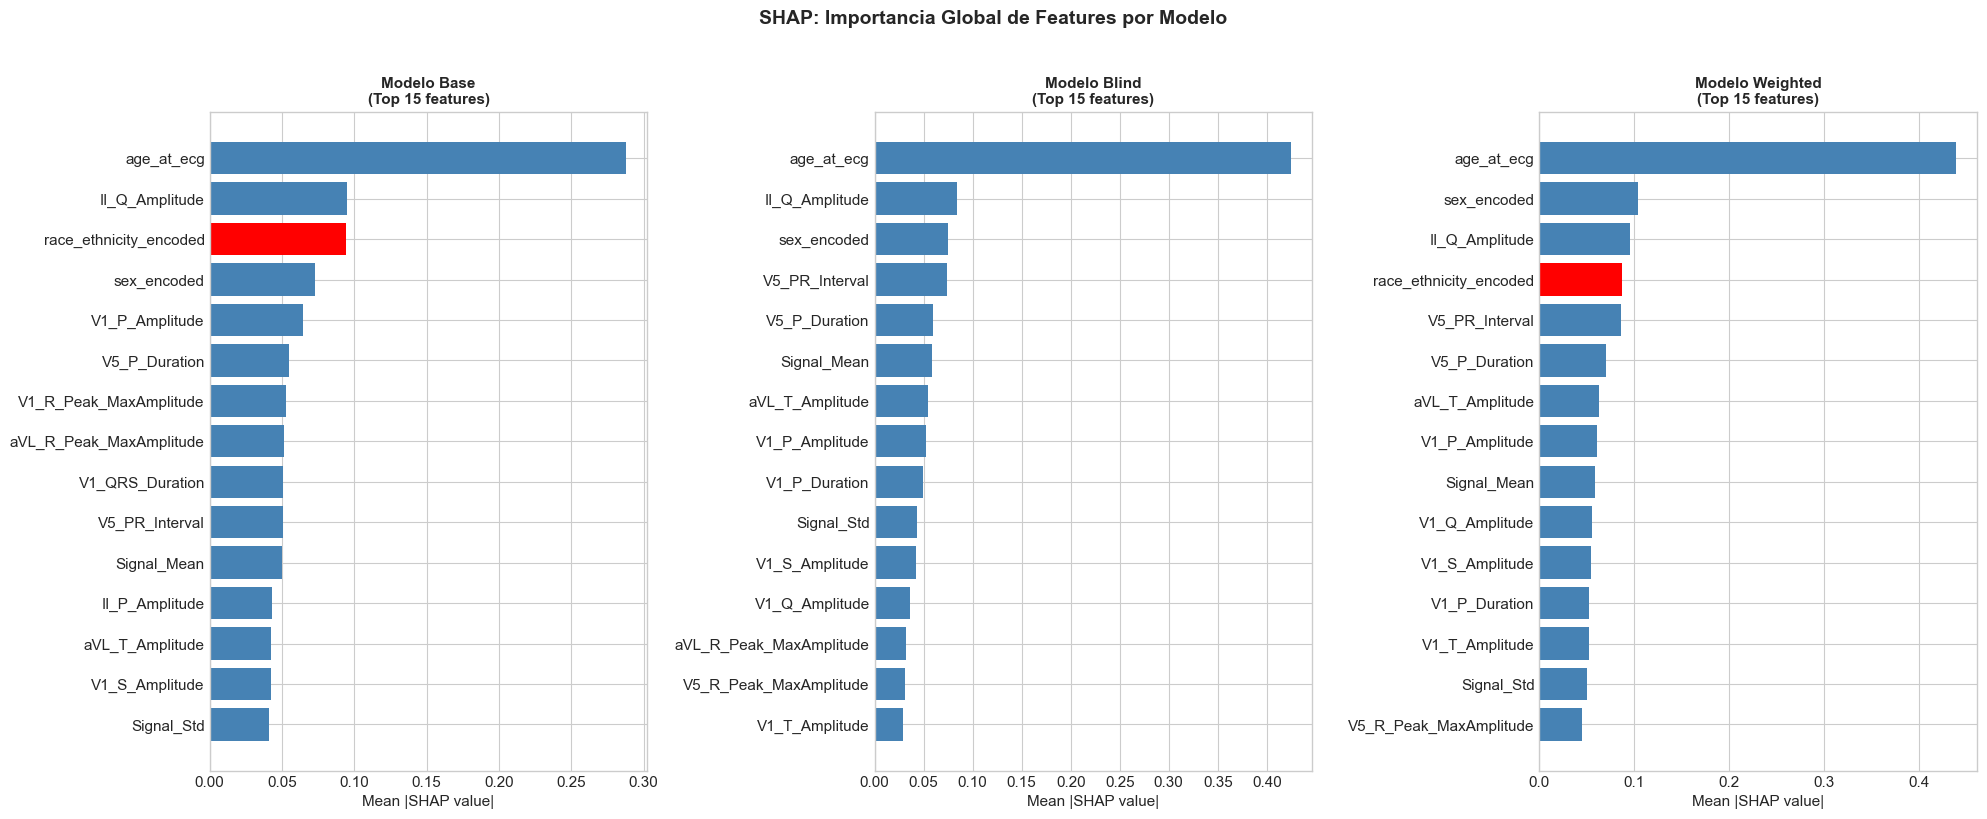

In [20]:
# Creo gráficos comparativos de SHAP 
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

for idx, (name, info) in enumerate(MODELS.items()):
    features = info['features']
    feature_importance = shap_importance_dict[name]
    
    print(f"{name}: {len(features)} features, importance: {len(feature_importance)} valores")
    
    # 15 características más importantes
    n_top = min(15, len(features), len(feature_importance))
    sorted_idx = np.argsort(feature_importance)[-n_top:]
    
    top_features = [features[i] for i in sorted_idx]
    top_values = feature_importance[sorted_idx]
    
    colors = ['red' if f == SENSITIVE_FEATURE else 'steelblue' for f in top_features]
    
    axes[idx].barh(range(len(top_values)), top_values, color=colors)
    axes[idx].set_yticks(range(len(top_values)))
    axes[idx].set_yticklabels(top_features)
    axes[idx].set_title(f'Modelo {name}\n(Top {n_top} features)', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Mean |SHAP value|')

plt.suptitle('SHAP: Importancia Global de Features por Modelo', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()
plt.close()

SHAP LOCAL: EXPLICACIONES PARA CASOS ESPECÍFICOS
CASO: TP Original (idx=1000) (idx=1000)
Diagnóstico real: Estenosis

--- Modelo Base ---
Predicción: Estenosis (prob: 56.72%) Correcto


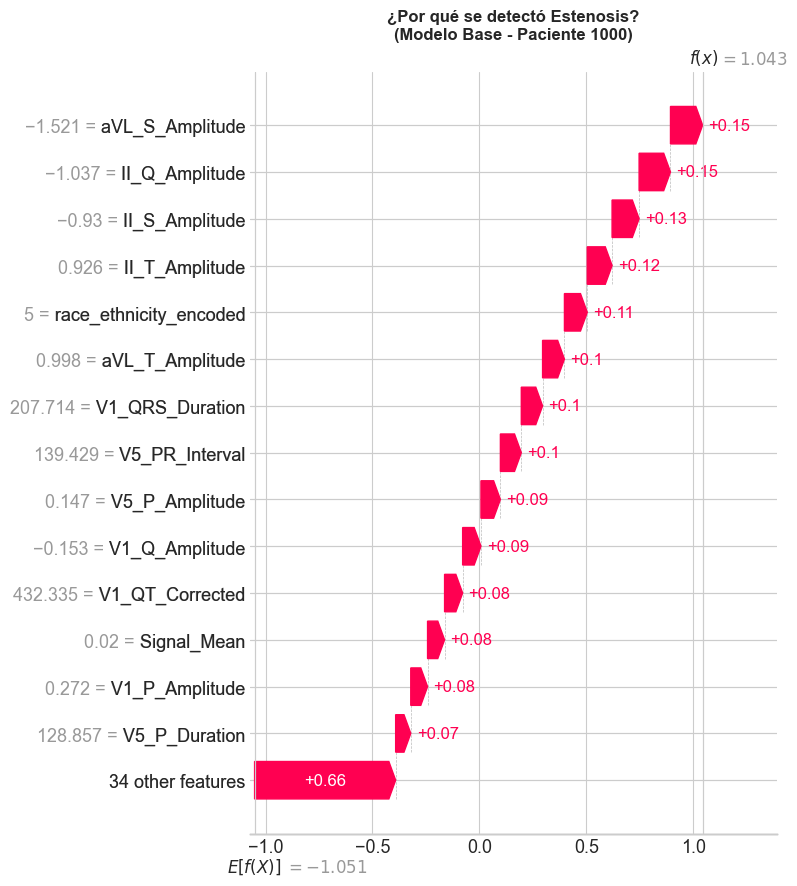

Aviso: race_ethnicity_encoded en top-15 (#5, SHAP=0.1068)

--- Modelo Blind ---
Predicción: Insuficiencia (prob: 59.94%) Incorrecto


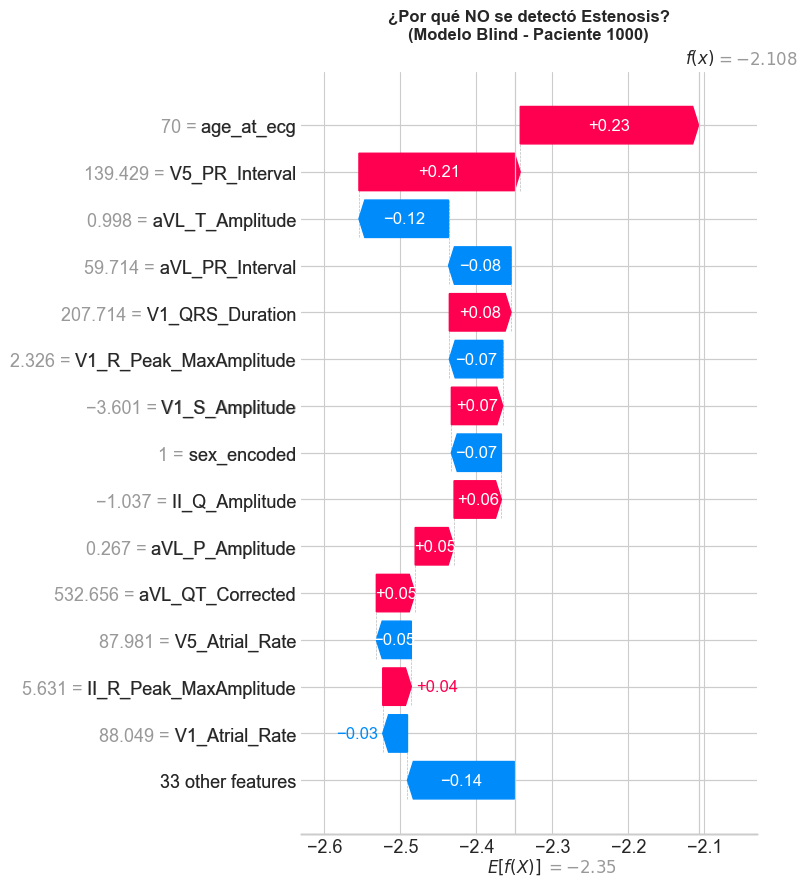


--- Modelo Weighted ---
Predicción: Ninguna (prob: 44.09%) Incorrecto


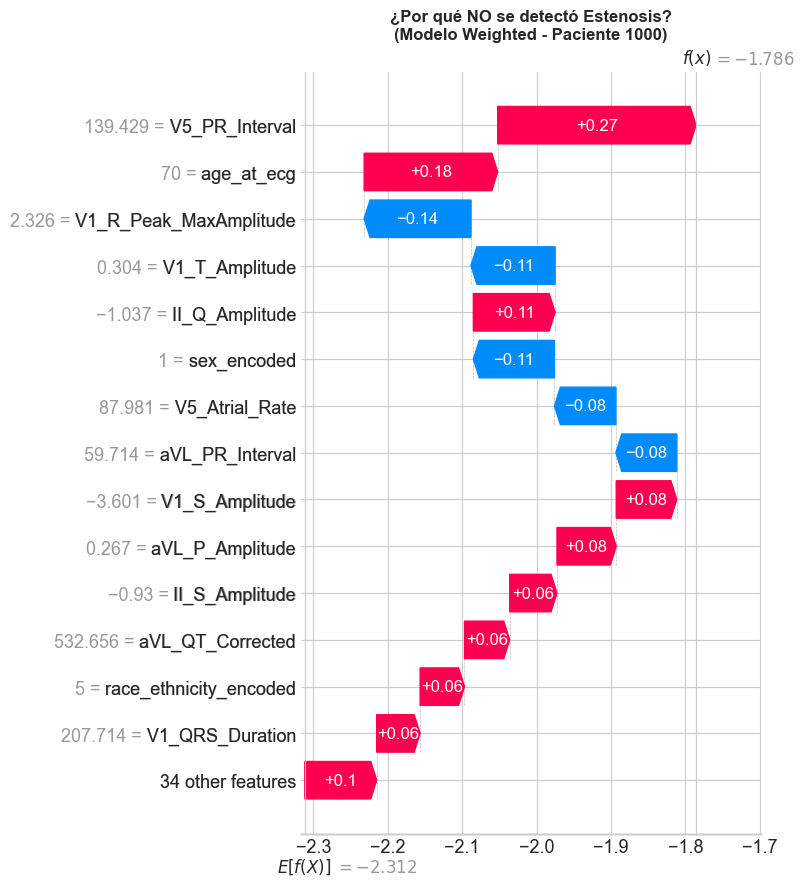

Aviso: race_ethnicity_encoded en top-15 (#13, SHAP=0.0597)
CASO: FN Original (idx=48) (idx=48)
Diagnóstico real: Estenosis

--- Modelo Base ---
Predicción: Ninguna (prob: 47.10%) Incorrecto


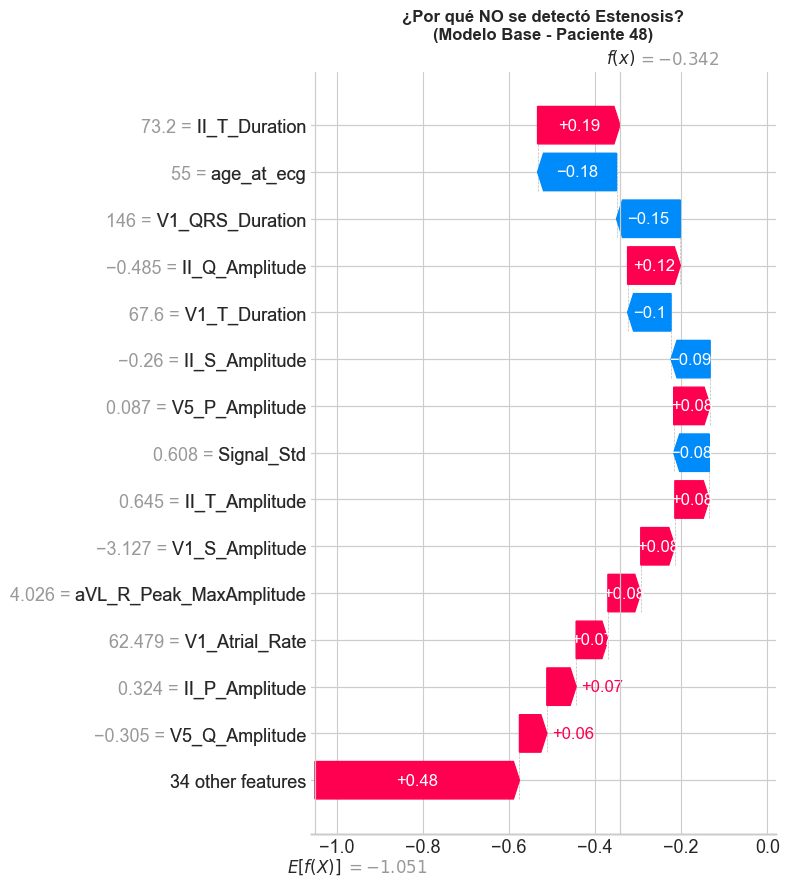

race_ethnicity_encoded fuera de top-15 (#40)

--- Modelo Blind ---
Predicción: Insuficiencia (prob: 59.78%) Incorrecto


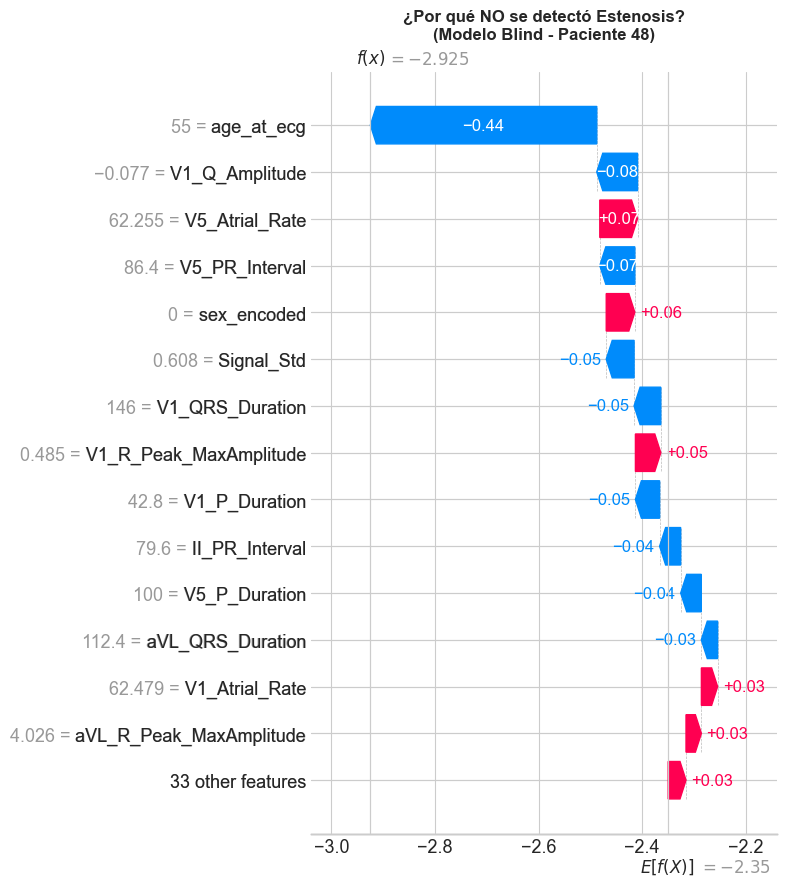


--- Modelo Weighted ---
Predicción: Ninguna (prob: 53.46%) Incorrecto


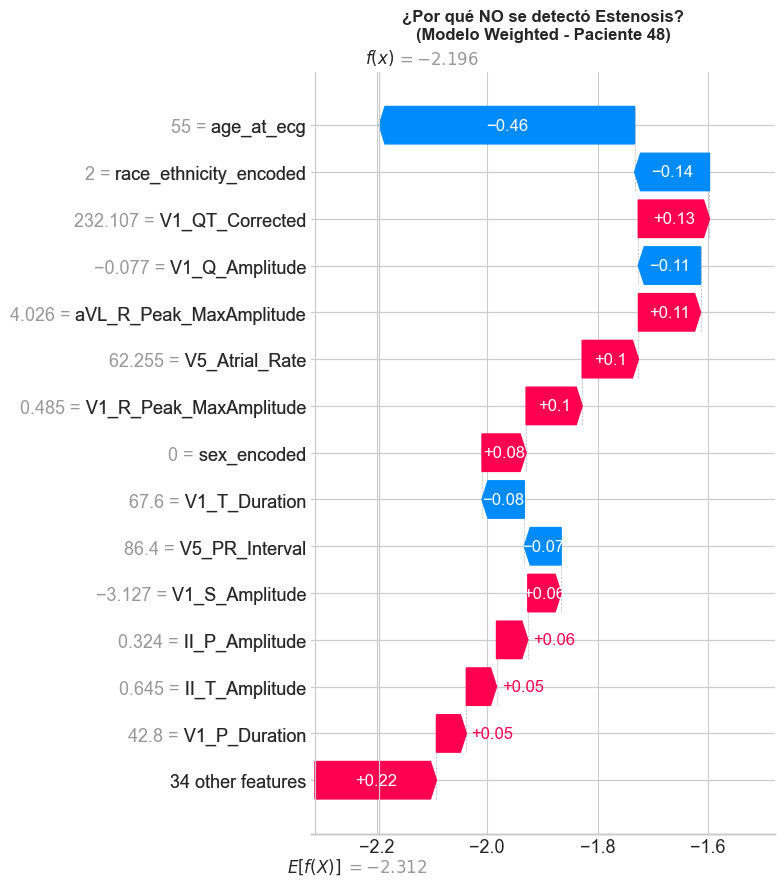

Aviso: race_ethnicity_encoded en top-15 (#2, SHAP=-0.1356)


In [ ]:
# Defino los casos de estudio para análisis local SHAP
print("SHAP LOCAL: EXPLICACIONES PARA CASOS ESPECÍFICOS")

for case_name, idx in STUDY_CASES.items():
    y_real = y_val.iloc[idx]
    
    print(f"CASO: {case_name} (idx={idx})")
    print(f"Diagnóstico real: {CLASS_NAMES[y_real]}")
       
    for name, info in MODELS.items():
        print(f"Modelo {name}")
        
        # Predicción del modelo
        X_case = info['X_val'].iloc[[idx]]
        pred = int(info['model'].predict(X_case).flatten()[0])
        proba = info['model'].predict_proba(X_case)[0]
        
        is_correcto = "Correcto" if pred == y_real else "Incorrecto"
        print(f"Predicción: {CLASS_NAMES[pred]} (prob: {proba[pred]:.2%}) {is_correcto}")
        
        # Obtengo los valores de SHAP
        shap_vals = shap_values_dict[name]
        features = info['features']
        
        # Calculo expected values (base values) desde shap_raw
        if name == 'Blind':
            pool = Pool(info['X_val'], cat_features=categorical_blind)
        else:
            pool = Pool(info['X_val'], cat_features=CATEGORICAL_FEATURES)
        
        shap_raw = info['model'].get_feature_importance(data=pool, type='ShapValues')
        
        # Expected values son la última columna de cada clase
        expected_values = shap_raw[0, :, -1]  # Shape: (n_classes,)
        
        # SHAP values para este caso (sin expected value)
        # Shape original: (n_samples, n_classes, n_features + 1)
        shap_sample = shap_raw[:, :, :-1]
        
        # Creo explicación SHAP para la clase REAL
        shap_exp = shap.Explanation(
            values=shap_sample[idx, y_real, :],
            base_values=expected_values[y_real],
            data=info['X_val'].iloc[idx].values,
            feature_names=features
        )
        
        # Seleccion el título según si es TP o no
        if pred == y_real:
            title = f"¿Por qué se detectó {CLASS_NAMES[y_real]}?\n(Modelo {name} - Paciente {idx})"
        else:
            title = f"¿Por qué NO se detectó {CLASS_NAMES[y_real]}?\n(Modelo {name} - Paciente {idx})"
        
        # Creo el grafico waterfall
        plt.figure(figsize=(12, 8))
        plt.title(title, fontsize=12, fontweight='bold')
        shap.plots.waterfall(shap_exp, max_display=15, show=False)
        plt.tight_layout()
        plt.show()
        plt.close()
        
        # Verifico si race_ethnicity está en top-15
        if SENSITIVE_FEATURE in features:
            idx_race = features.index(SENSITIVE_FEATURE)
            shap_race = shap_sample[idx, y_real, idx_race]
            
            # Ranking en este caso específico
            case_level_explanations = np.abs(shap_sample[idx, y_real, :])
            title = len(features) - np.argsort(np.argsort(case_level_explanations))[idx_race]
            
            if title <= 15:
                print(f"Aviso: race_ethnicity_encoded en top-15 (#{title}, SHAP={shap_race:.4f})")
            else:
                print(f"race_ethnicity_encoded fuera de top-15 (#{title})")


## XAI: Análisis LIME Comparativo

In [53]:
# Creo los explainers LIME para los tres modelos
print("LIME: CONFIGURANDO EXPLAINERS")

lime_explainers = {}

for name, info in MODELS.items():
    print(f"Configurando LIME para modelo {name}...")
    
    # Identificar features categóricas
    features = info['features']
    if name == 'Blind':
        cat_indices = [features.index(c) for c in categorical_blind if c in features]
    else:
        cat_indices = [features.index(c) for c in CATEGORICAL_FEATURES if c in features]
    
    # Crear explainer LIME
    explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=info['X_val'].values if name != 'Blind' else X_val_blind.values,
        feature_names=features,
        class_names=[CLASS_NAMES[i] for i in range(N_CLASSES)],
        categorical_features=cat_indices,
        mode='classification',
        random_state=RANDOM_STATE
    )
    
    lime_explainers[name] = explainer
    print(f"Completado")

LIME: CONFIGURANDO EXPLAINERS
Configurando LIME para modelo Base...
Completado
Configurando LIME para modelo Blind...
Completado
Configurando LIME para modelo Weighted...
Completado


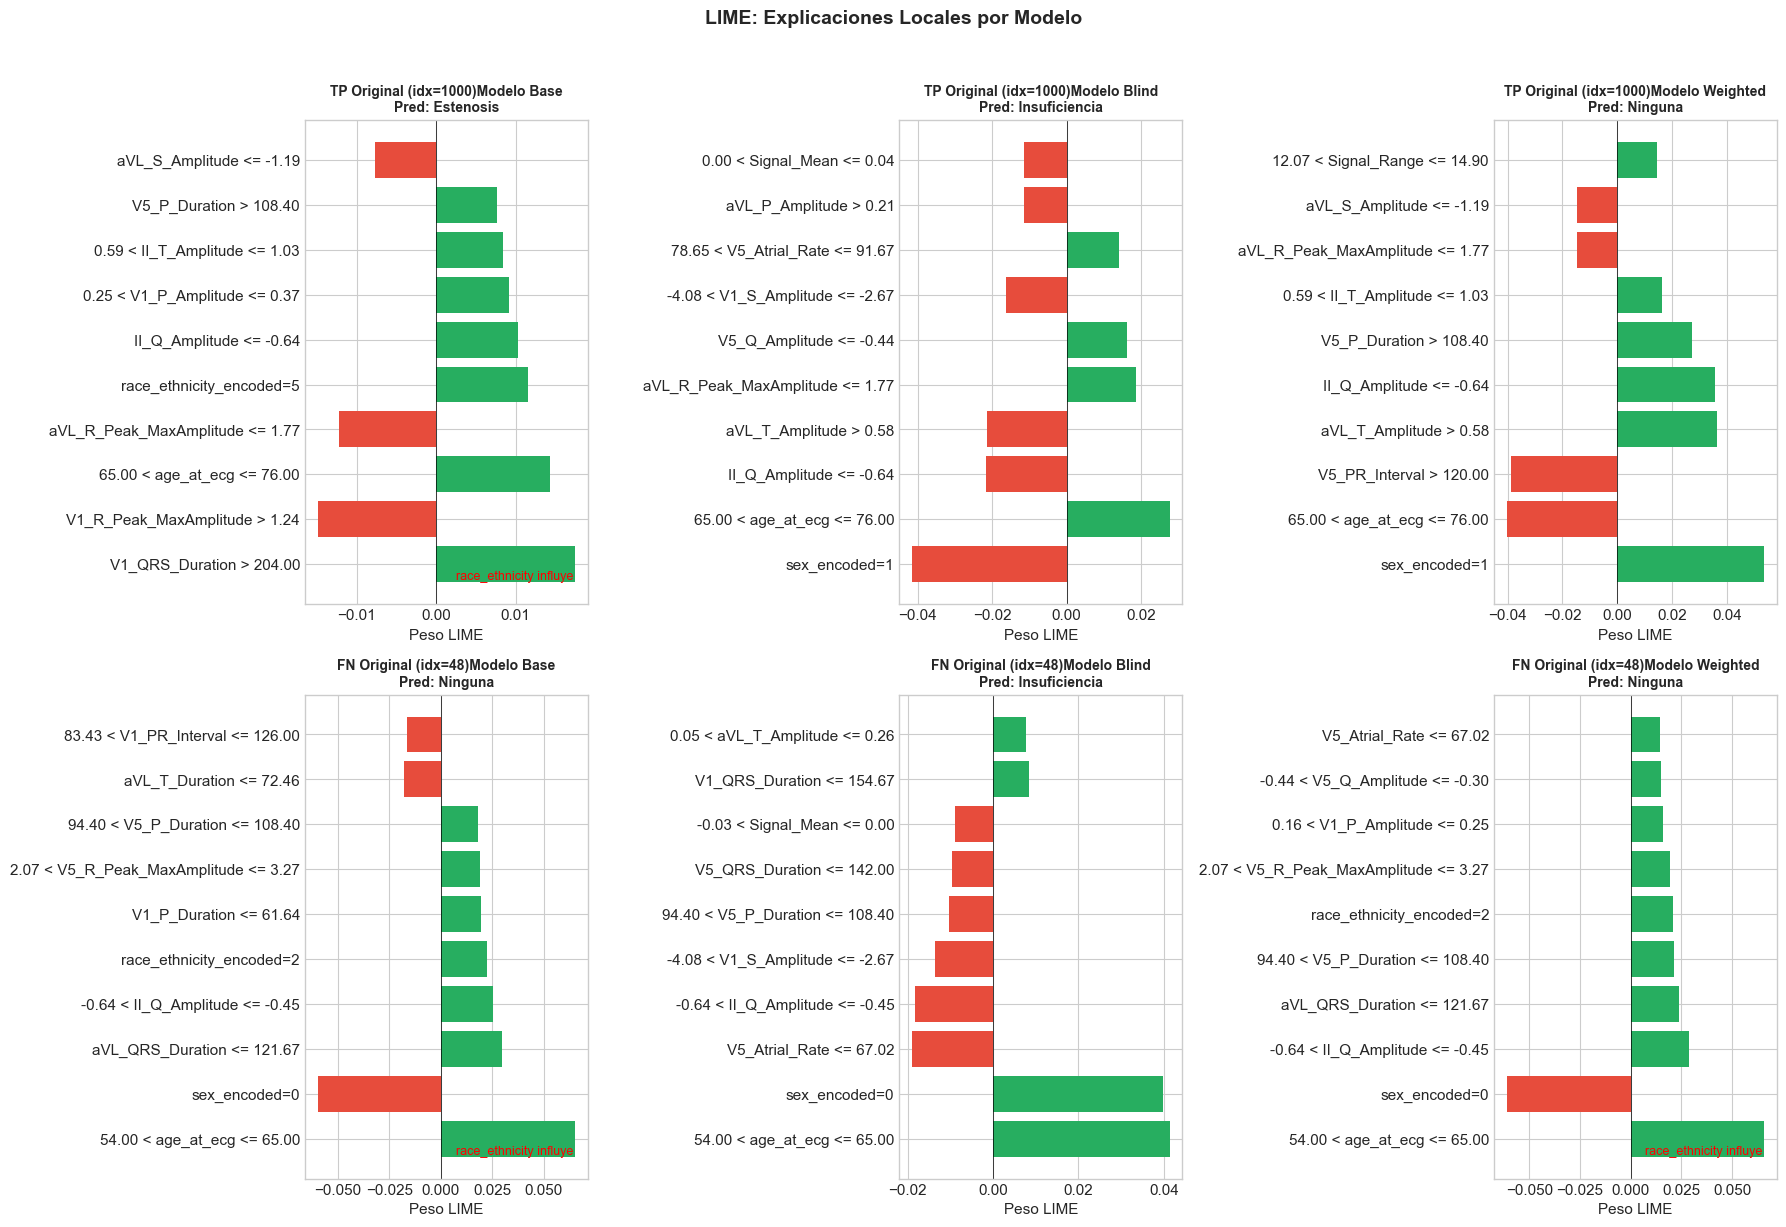

In [ ]:
# Creo los gráficos comparativos de LIME para los casos específicos
fig, axes = plt.subplots(len(STUDY_CASES), len(MODELS), figsize=(6*len(MODELS), 6*len(STUDY_CASES)))

for i, (case_name, idx) in enumerate(STUDY_CASES.items()):
    y_real = y_val.iloc[idx]
    
    for j, (name, info) in enumerate(MODELS.items()):
        ax = axes[i, j] if len(STUDY_CASES) > 1 else axes[j]
        
        exp = lime_explanations[case_name][name]
        pred = int(info['model'].predict(info['X_val'].iloc[[idx]]).flatten()[0])
        
        # Obtengo la explicación como una lista
        exp_list = exp.as_list(label=pred)
        
        features_lime = [x[0] for x in exp_list[:10]]
        weights_lime = [x[1] for x in exp_list[:10]]
        
        colors = ['#e74c3c' if w < 0 else '#27ae60' for w in weights_lime]
        
        ax.barh(range(len(features_lime)), weights_lime, color=colors)
        ax.set_yticks(range(len(features_lime)))
        ax.set_yticklabels(features_lime)
        ax.axvline(x=0, color='black', linewidth=0.5)
        ax.set_title(f'{case_name}Modelo {name}\nPred: {CLASS_NAMES[pred]}', 
                    fontsize=10, fontweight='bold')
        ax.set_xlabel('Peso LIME')
        
        # Marco si race_ethnicity influye
        if any(SENSITIVE_FEATURE in f for f in features_lime):
            ax.annotate('race_ethnicity influye', xy=(0.95, 0.05), 
                       xycoords='axes fraction', ha='right', fontsize=9, color='red')

plt.suptitle('LIME: Explicaciones Locales por Modelo', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()
plt.close()

## XAI: Análisis DiCE (Contrafactuales)

In [68]:
# Crear los explainers DiCE para los tres modelos
print("DiCE: CONFIGURANDO GENERADOR DE CONTRAFACTUALES")

# Creo una clase wrapper adaptada para CatBoost en DiCE
class ModelWrapper:
    def __init__(self, model, cat_features):
        self.model = model
        self.cat_features = cat_features

    def predict(self, X):
        X_clean = X.copy()
        for col in self.cat_features:
            if col in X_clean.columns:
                X_clean[col] = X_clean[col].astype(int)
        return self.model.predict(X_clean).flatten()

    def predict_proba(self, X):
        X_clean = X.copy()
        for col in self.cat_features:
            if col in X_clean.columns:
                X_clean[col] = X_clean[col].astype(int)
        return self.model.predict_proba(X_clean)

# Características continuas (no categóricas)
CONTINUOUS_FEATURE_NAMES = [f for f in FEATURE_NAMES if f not in CATEGORICAL_FEATURES]

# Configuro DiCE para cada modelo
dice_configs = {}

for name, info in MODELS.items():
    print(f"\nConfigurando DiCE para modelo {name}...")
    
    features = info['features']
    
    if name == 'Blind':
        cat_features = categorical_blind
        X_train_dice = X_train_blind.copy()
        continuous_features = [f for f in features if f not in cat_features]
    else:
        cat_features = CATEGORICAL_FEATURES
        X_train_dice = X_train.copy()
        continuous_features = CONTINUOUS_FEATURE_NAMES
    
    # Creo el wrapper
    wrapper = ModelWrapper(info['model'], cat_features)
    
    # Configuro DiCE Data
    df_dice = pd.concat([X_train_dice, y_train.rename('target')], axis=1)
    
    d_dice = dice_ml.Data(
        dataframe=df_dice,
        continuous_features=continuous_features,
        outcome_name='target'
    )
    
    # Configuro DiCE Model
    m_dice = dice_ml.Model(model=wrapper, backend="sklearn", model_type="classifier")
    
    # Creo el explainer
    exp_dice = dice_ml.Dice(d_dice, m_dice, method="random")
    
    dice_configs[name] = {
        'explainer': exp_dice,
        'wrapper': wrapper,
        'cat_features': cat_features,
        'features': features
    }

DiCE: CONFIGURANDO GENERADOR DE CONTRAFACTUALES

Configurando DiCE para modelo Base...

Configurando DiCE para modelo Blind...

Configurando DiCE para modelo Weighted...


In [71]:
# Genero contrafactuales para los casos específicos
print("DiCE: CONTRAFACTUALES PARA CASOS ESPECÍFICOS")

dice_results = {}

for case_name, idx in STUDY_CASES.items():
    print(f"CASO: {case_name} (idx={idx})")
    
    y_real = y_val.iloc[idx]
    patient = X_val.iloc[idx]
    race_original = int(patient[SENSITIVE_FEATURE])
    
    print(f"Grupo étnico original: {RACE_ETHNICITY.get(race_original, race_original)}")
    print(f"Diagnóstico real: {CLASS_NAMES[y_real]}")
    
    dice_results[case_name] = {}
    
    for name, info in MODELS.items():
        print(f"Modelo {name}")
        
        dice_info = dice_configs[name]
        dice_exp = dice_info['explainer']
        cat_features = dice_info['cat_features']
        features = dice_info['features']
        
        # Preparo la consulta con los tipos correctos
        query = info['X_val'].iloc[[idx]].copy()
        for cat_col in cat_features:
            if cat_col in query.columns:
                query[cat_col] = query[cat_col].astype(int).astype('category')
        
        # Obtengo la predicción actual
        pred_actual = int(info['model'].predict(info['X_val'].iloc[[idx]]).flatten()[0])
        print(f"Predicción actual: {CLASS_NAMES[pred_actual]}")
        
        # Listo las clases a intentar (priorizando la real, luego otras)
        trial_classes = []
        if pred_actual != y_real:
            trial_classes.append(int(y_real))
        trial_classes.extend([c for c in CLASS_NAMES.keys() if c != pred_actual and c not in trial_classes])
        
        cf_found = False
        cf_df = None
        
        for desired_class in trial_classes:
            print(f"Intentando clase deseada: {CLASS_NAMES[desired_class]}...")
            
            try:
                # Genero contrafactuales con parámetros más flexibles
                cf = dice_exp.generate_counterfactuals(
                    query,
                    total_CFs=3,
                    desired_class=desired_class,
                    features_to_vary='all',        # Permito variar todas las características
                    permitted_range=None,          # Sin restricciones de rango
                    random_seed=RANDOM_STATE
                )
                cf.visualize_as_dataframe(show_only_changes=True)
                cf_df = cf.cf_examples_list[0].final_cfs_df
                
                if cf_df is not None and len(cf_df) > 0:
                    print(f"Contrafactuales encontrados para clase {CLASS_NAMES[desired_class]}")
                    cf_found = True
                    break
                    
            except Exception as e:
                if "No counterfactuals found" in str(e):
                    print(f"No se encontraron CFs para {CLASS_NAMES[desired_class]}")
                    continue
                else:
                    print(f"Error: {str(e)[:50]}...")
                    continue
        
        if not cf_found:
            print(f"No se pudieron generar contrafactuales para ninguna clase")
            dice_results[case_name][name] = None
            continue
        
        dice_results[case_name][name] = cf_df
        
        # Verifico si sugiere cambiar race_ethnicity
        if SENSITIVE_FEATURE in cf_df.columns:
            cf_race_values = cf_df[SENSITIVE_FEATURE].astype(float).astype(int)
            race_ethnicity_change = cf_race_values != race_original
            
            if race_ethnicity_change.any():
                print(f"ALERTA ÉTICA: DiCE sugiere cambiar {SENSITIVE_FEATURE}")
                print(f"Original: {RACE_ETHNICITY.get(race_original, race_original)}")
                for new_race_ethnicity in cf_race_values[race_ethnicity_change].unique():
                    print(f"Sugerido: {RACE_ETHNICITY.get(int(new_race_ethnicity), new_race_ethnicity)}")
            else:
                print(f"No sugiere cambiar {SENSITIVE_FEATURE}")
        else:
            print(f"{SENSITIVE_FEATURE} no disponible (excluida del modelo)")
        
        # Muestro las características que cambian
        print(f"Features modificadas:")
        n_changes = 0
        for col in cf_df.columns:
            if col not in ['target', SENSITIVE_FEATURE]:
                original_val = query[col].values[0]
                if hasattr(original_val, 'item'):
                    original_val = original_val.item()
                
                for cf_val in cf_df[col]:
                    if hasattr(cf_val, 'item'):
                        cf_val = cf_val.item()
                    if cf_val != original_val:
                        n_changes += 1
                        print(f"{col}: {original_val:.2f} → {cf_val:.2f}" if isinstance(original_val, float) else f"    • {col}: {original_val} → {cf_val}")
                        break
        
        if n_changes == 0:
            print(f"(ninguna)")

DiCE: CONTRAFACTUALES PARA CASOS ESPECÍFICOS
CASO: TP Original (idx=1000) (idx=1000)
Grupo étnico original: white
Diagnóstico real: Estenosis
Modelo Base
Predicción actual: Estenosis
Intentando clase deseada: Ambas...


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.90s/it]

Query instance (original outcome : 1)


,II_T_Amplitude,race_ethnicity_encoded,II_PR_Interval,V1_P_Duration,Signal_Std,II_QT_Corrected,V1_R_Peak_MaxAmplitude,age_at_ecg,V1_QT_Corrected,V5_PR_Interval,...,V5_Q_Amplitude,II_S_Amplitude,V1_Atrial_Rate,V5_Atrial_Rate,II_P_Duration,V5_T_Duration,V1_T_Amplitude,II_QRS_Duration,aVL_P_Amplitude,target
0,0.925797,NaN,155.142853,74.0,0.907785,468.060608,2.326204,70.0,432.335266,139.428574,...,-0.582331,-0.930425,88.049347,87.980789,128.571426,134.0,0.304065,144.285721,0.267363,1



Diverse Counterfactual set (new outcome: 0)


,II_T_Amplitude,race_ethnicity_encoded,II_PR_Interval,V1_P_Duration,Signal_Std,II_QT_Corrected,V1_R_Peak_MaxAmplitude,age_at_ecg,V1_QT_Corrected,V5_PR_Interval,...,V5_Q_Amplitude,II_S_Amplitude,V1_Atrial_Rate,V5_Atrial_Rate,II_P_Duration,V5_T_Duration,V1_T_Amplitude,II_QRS_Duration,aVL_P_Amplitude,target
0,-,5.0,-,-,-,-,-,-,278.9894,-,...,-,-,-,-,-,-,-,-,-,0.0
1,-,5.0,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,0.0
2,-,5.0,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,0.0


Contrafactuales encontrados para clase Ambas
No sugiere cambiar race_ethnicity_encoded
Features modificadas:
V1_QT_Corrected: 432.34 → 278.99
aVL_T_Amplitude: 1.00 → -0.81
V1_Q_Amplitude: -0.15 → 3.78
II_Q_Amplitude: -1.04 → 2.11
V5_P_Amplitude: 0.15 → 4.94
Modelo Blind
Predicción actual: Insuficiencia
Intentando clase deseada: Estenosis...


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No se encontraron CFs para Estenosis
Intentando clase deseada: Ambas...


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]

Query instance (original outcome : 2)


,II_T_Amplitude,II_PR_Interval,V1_P_Duration,Signal_Std,II_QT_Corrected,V1_R_Peak_MaxAmplitude,age_at_ecg,V1_QT_Corrected,V5_PR_Interval,II_R_Peak_MaxAmplitude,...,V5_Q_Amplitude,II_S_Amplitude,V1_Atrial_Rate,V5_Atrial_Rate,II_P_Duration,V5_T_Duration,V1_T_Amplitude,II_QRS_Duration,aVL_P_Amplitude,target
0,0.925797,155.142853,74.0,0.907785,468.060608,2.326204,70.0,432.335266,139.428574,5.63118,...,-0.582331,-0.930425,88.049347,87.980789,128.571426,134.0,0.304065,144.285721,0.267363,2



Diverse Counterfactual set (new outcome: 0)


,II_T_Amplitude,II_PR_Interval,V1_P_Duration,Signal_Std,II_QT_Corrected,V1_R_Peak_MaxAmplitude,age_at_ecg,V1_QT_Corrected,V5_PR_Interval,II_R_Peak_MaxAmplitude,...,V5_Q_Amplitude,II_S_Amplitude,V1_Atrial_Rate,V5_Atrial_Rate,II_P_Duration,V5_T_Duration,V1_T_Amplitude,II_QRS_Duration,aVL_P_Amplitude,target
0,-,810.7,336.7,3.5703011,-,-,82.2,-,-,-,...,-,-,163.92401,-,-,-,-,-,-,0.0
1,5.9529826,-,-,-,-,-,88.7,876.4698,-,-,...,-,-,-,-,-,-,-,-,-,0.0
2,-,-,-,-,-,9.26821386,87.7,865.5674,-,12.4287743,...,-,-,-,-,372.3,-,-,-,-,0.0


Contrafactuales encontrados para clase Ambas
race_ethnicity_encoded no disponible (excluida del modelo)
Features modificadas:
II_T_Amplitude: 0.93 → 5.95
II_PR_Interval: 155.14 → 810.70
V1_P_Duration: 74.00 → 336.70
Signal_Std: 0.91 → 3.57
V1_R_Peak_MaxAmplitude: 2.33 → 9.27
age_at_ecg: 70.00 → 82.20
V1_QT_Corrected: 432.34 → 876.47
II_R_Peak_MaxAmplitude: 5.63 → 12.43
    • sex_encoded: 1 → nan
Signal_Mean: 0.02 → 0.33
II_Q_Amplitude: -1.04 → 2.45
V5_QRS_Duration: 156.29 → 707.20
V5_R_Peak_MaxAmplitude: 3.99 → 10.91
V1_QRS_Duration: 207.71 → 730.80
aVL_S_Amplitude: -1.52 → 5.79
aVL_R_Peak_MaxAmplitude: 0.65 → 11.04
V5_S_Amplitude: -0.64 → 2.31
V5_P_Duration: 128.86 → 326.10
V5_QT_Corrected: 490.07 → 799.47
aVL_P_Duration: 79.71 → 367.70
V1_Atrial_Rate: 88.05 → 163.92
II_P_Duration: 128.57 → 372.30
Modelo Weighted
Predicción actual: Ninguna
Intentando clase deseada: Estenosis...


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No se encontraron CFs para Estenosis
Intentando clase deseada: Ambas...


100%|██████████| 1/1 [00:01<00:00,  1.87s/it]

Query instance (original outcome : 3)


,II_T_Amplitude,race_ethnicity_encoded,II_PR_Interval,V1_P_Duration,Signal_Std,II_QT_Corrected,V1_R_Peak_MaxAmplitude,age_at_ecg,V1_QT_Corrected,V5_PR_Interval,...,V5_Q_Amplitude,II_S_Amplitude,V1_Atrial_Rate,V5_Atrial_Rate,II_P_Duration,V5_T_Duration,V1_T_Amplitude,II_QRS_Duration,aVL_P_Amplitude,target
0,0.925797,NaN,155.142853,74.0,0.907785,468.060608,2.326204,70.0,432.335266,139.428574,...,-0.582331,-0.930425,88.049347,87.980789,128.571426,134.0,0.304065,144.285721,0.267363,3



Diverse Counterfactual set (new outcome: 0)


,II_T_Amplitude,race_ethnicity_encoded,II_PR_Interval,V1_P_Duration,Signal_Std,II_QT_Corrected,V1_R_Peak_MaxAmplitude,age_at_ecg,V1_QT_Corrected,V5_PR_Interval,...,V5_Q_Amplitude,II_S_Amplitude,V1_Atrial_Rate,V5_Atrial_Rate,II_P_Duration,V5_T_Duration,V1_T_Amplitude,II_QRS_Duration,aVL_P_Amplitude,target
0,-,5.0,-,-,-,-,-,82.2,-,-,...,-,-,-,-,-,-,-,-,-,0.0
1,-,5.0,-,-,-,-,-,85.4,-,-,...,-,-,-,-,-,-,-,-,-,0.0
2,-,5.0,-,-,-,-,-,85.8,-,-,...,-,-,-,-,-,-,-,-,-,0.0


Contrafactuales encontrados para clase Ambas
No sugiere cambiar race_ethnicity_encoded
Features modificadas:
age_at_ecg: 70.00 → 82.20
aVL_R_Peak_MaxAmplitude: 0.65 → 11.04
Signal_Range: 13.32 → 18.46
CASO: FN Original (idx=48) (idx=48)
Grupo étnico original: hispanic
Diagnóstico real: Estenosis
Modelo Base
Predicción actual: Ninguna
Intentando clase deseada: Estenosis...


100%|██████████| 1/1 [00:01<00:00,  1.90s/it]

Query instance (original outcome : 3)


,II_T_Amplitude,race_ethnicity_encoded,II_PR_Interval,V1_P_Duration,Signal_Std,II_QT_Corrected,V1_R_Peak_MaxAmplitude,age_at_ecg,V1_QT_Corrected,V5_PR_Interval,...,V5_Q_Amplitude,II_S_Amplitude,V1_Atrial_Rate,V5_Atrial_Rate,II_P_Duration,V5_T_Duration,V1_T_Amplitude,II_QRS_Duration,aVL_P_Amplitude,target
0,0.644824,NaN,79.599998,42.799999,0.607772,465.55896,0.484737,55.0,232.106964,86.400002,...,-0.304941,-0.259535,62.479107,62.25536,70.400002,115.199997,0.303644,130.399994,0.1571,3



Diverse Counterfactual set (new outcome: 1)


,II_T_Amplitude,race_ethnicity_encoded,II_PR_Interval,V1_P_Duration,Signal_Std,II_QT_Corrected,V1_R_Peak_MaxAmplitude,age_at_ecg,V1_QT_Corrected,V5_PR_Interval,...,V5_Q_Amplitude,II_S_Amplitude,V1_Atrial_Rate,V5_Atrial_Rate,II_P_Duration,V5_T_Duration,V1_T_Amplitude,II_QRS_Duration,aVL_P_Amplitude,target
0,-,2.0,-,-,-,-,-,73.2,-,-,...,-,-,-,-,-,-,-,-,-,1.0
1,-,2.0,-,-,-,-,-,70.3,-,-,...,-,-,-,-,-,-,-,-,-,1.0
2,-,2.0,687.8,-,-,-,-,72.4,-,-,...,-,-,-,-,-,-,-,-,-,1.0


Contrafactuales encontrados para clase Estenosis
No sugiere cambiar race_ethnicity_encoded
Features modificadas:
II_PR_Interval: 79.60 → 687.80
age_at_ecg: 55.00 → 73.20
II_R_Peak_MaxAmplitude: 2.87 → 9.14
Modelo Blind
Predicción actual: Insuficiencia
Intentando clase deseada: Estenosis...


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No se encontraron CFs para Estenosis
Intentando clase deseada: Ambas...


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]

Query instance (original outcome : 2)


,II_T_Amplitude,II_PR_Interval,V1_P_Duration,Signal_Std,II_QT_Corrected,V1_R_Peak_MaxAmplitude,age_at_ecg,V1_QT_Corrected,V5_PR_Interval,II_R_Peak_MaxAmplitude,...,V5_Q_Amplitude,II_S_Amplitude,V1_Atrial_Rate,V5_Atrial_Rate,II_P_Duration,V5_T_Duration,V1_T_Amplitude,II_QRS_Duration,aVL_P_Amplitude,target
0,0.644824,79.599998,42.799999,0.607772,465.55896,0.484737,55.0,232.106964,86.400002,2.865761,...,-0.304941,-0.259535,62.479107,62.25536,70.400002,115.199997,0.303644,130.399994,0.1571,2



Diverse Counterfactual set (new outcome: 0)


,II_T_Amplitude,II_PR_Interval,V1_P_Duration,Signal_Std,II_QT_Corrected,V1_R_Peak_MaxAmplitude,age_at_ecg,V1_QT_Corrected,V5_PR_Interval,II_R_Peak_MaxAmplitude,...,V5_Q_Amplitude,II_S_Amplitude,V1_Atrial_Rate,V5_Atrial_Rate,II_P_Duration,V5_T_Duration,V1_T_Amplitude,II_QRS_Duration,aVL_P_Amplitude,target
0,6.03856954,-,-,3.9551732,810.00789,-,89.4,-,689.6,-,...,3.524595119,-,-,-,-,-,-,591.0,-,0.0
1,6.04712267,901.9,-,-,-,-,89.5,884.7227,690.3,-,...,-,2.83706243,-,-,-,-,-,591.5,5.530175328,0.0
2,-,-,-,-,-,9.77483077,90.0,-,694.7,-,...,-,-,-,-,-,-,-,-,-,0.0


Contrafactuales encontrados para clase Ambas
race_ethnicity_encoded no disponible (excluida del modelo)
Features modificadas:
II_T_Amplitude: 0.64 → 6.04
II_PR_Interval: 79.60 → 901.90
Signal_Std: 0.61 → 3.96
II_QT_Corrected: 465.56 → 810.01
V1_R_Peak_MaxAmplitude: 0.48 → 9.77
age_at_ecg: 55.00 → 89.40
V1_QT_Corrected: 232.11 → 884.72
V5_PR_Interval: 86.40 → 689.60
aVL_T_Amplitude: 0.26 → 9.86
    • sex_encoded: 0 → nan
V1_P_Amplitude: 0.21 → 5.53
Signal_Mean: 0.00 → 0.33
II_Q_Amplitude: -0.48 → 2.55
V5_R_Peak_MaxAmplitude: 2.66 → 12.53
V5_P_Amplitude: 0.09 → 5.30
V1_QRS_Duration: 146.00 → 738.30
aVL_S_Amplitude: -0.32 → 6.00
V5_P_Duration: 100.00 → 361.90
V1_PR_Interval: 123.60 → 822.50
V5_QT_Corrected: 481.87 → 880.75
aVL_QRS_Duration: 112.40 → 500.20
aVL_T_Duration: 58.40 → 317.20
V1_T_Duration: 67.60 → 377.40
II_P_Amplitude: 0.32 → 5.36
II_T_Duration: 73.20 → 333.80
V5_Q_Amplitude: -0.30 → 3.52
II_S_Amplitude: -0.26 → 2.84
II_QRS_Duration: 130.40 → 591.00
aVL_P_Amplitude: 0.16 → 5.

100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec
No se encontraron CFs para Estenosis
Intentando clase deseada: Ambas...


100%|██████████| 1/1 [00:01<00:00,  1.84s/it]

Query instance (original outcome : 3)


,II_T_Amplitude,race_ethnicity_encoded,II_PR_Interval,V1_P_Duration,Signal_Std,II_QT_Corrected,V1_R_Peak_MaxAmplitude,age_at_ecg,V1_QT_Corrected,V5_PR_Interval,...,V5_Q_Amplitude,II_S_Amplitude,V1_Atrial_Rate,V5_Atrial_Rate,II_P_Duration,V5_T_Duration,V1_T_Amplitude,II_QRS_Duration,aVL_P_Amplitude,target
0,0.644824,NaN,79.599998,42.799999,0.607772,465.55896,0.484737,55.0,232.106964,86.400002,...,-0.304941,-0.259535,62.479107,62.25536,70.400002,115.199997,0.303644,130.399994,0.1571,3



Diverse Counterfactual set (new outcome: 0)


,II_T_Amplitude,race_ethnicity_encoded,II_PR_Interval,V1_P_Duration,Signal_Std,II_QT_Corrected,V1_R_Peak_MaxAmplitude,age_at_ecg,V1_QT_Corrected,V5_PR_Interval,...,V5_Q_Amplitude,II_S_Amplitude,V1_Atrial_Rate,V5_Atrial_Rate,II_P_Duration,V5_T_Duration,V1_T_Amplitude,II_QRS_Duration,aVL_P_Amplitude,target
0,-,2.0,-,-,-,-,-,86.5,-,-,...,-,-,-,-,-,-,-,-,-,0.0
1,-,2.0,-,-,-,-,-,85.4,-,-,...,-,-,-,-,-,-,-,-,-,0.0
2,-,2.0,-,-,-,-,-,85.2,-,-,...,-,-,-,-,-,-,-,-,-,0.0


Contrafactuales encontrados para clase Ambas
No sugiere cambiar race_ethnicity_encoded
Features modificadas:
age_at_ecg: 55.00 → 86.50
V5_T_Amplitude: 0.49 → 7.57


In [76]:
# Hago una evalucaión para ver si DiCE sugiere cambiar la etnia
print("RESUMEN: ¿DiCE SUGIERE CAMBIAR ETNIA?")

summary_dice = []

for case_name, idx in STUDY_CASES.items():
    race_original = int(X_val.iloc[idx][SENSITIVE_FEATURE])
    
    for name in MODELS.keys():
        cf_df = dice_results.get(case_name, {}).get(name)
        
        if cf_df is None:
            suggestion = 'Error'
        elif SENSITIVE_FEATURE not in cf_df.columns:
            suggestion = 'N/A (excluida)'
        else:
            changes = (cf_df[SENSITIVE_FEATURE] != race_original).any()
            suggestion = 'SÍ' if changes else 'No'
        
        summary_dice.append({
            'Caso': case_name,
            'Modelo': name,
            'Sugiere_Cambiar_Etnia': suggestion
        })

df_summary_dice = pd.DataFrame(summary_dice)
pivot_dice = df_summary_dice.pivot(index='Caso', columns='Modelo', values='Sugiere_Cambiar_Etnia')

print(pivot_dice.to_string())

df_summary_dice.to_csv('resumen_DICE_cambio_etnia.csv', index=False)

RESUMEN: ¿DiCE SUGIERE CAMBIAR ETNIA?
Modelo                 Base           Blind Weighted
Caso                                                
FN Original (idx=48)     No  N/A (excluida)       No
TP Original (idx=1000)   No  N/A (excluida)       No


## Resumen

In [52]:
# Creo el resumen ejecutivo final

print("RESUMEN EJECUTIVO: ANÁLISIS DE EQUIDAD Y XAI")


print(f"1. MODELOS COMPARADOS")
print(f"{'Modelo':<12} {'Estrategia':<30} {'Accuracy':>10}")
print(f"{'-'*12} {'-'*30} {'-'*10}")
for name, info in MODELS.items():
    strategy = {
        'Base': 'Original (con race_ethnicity)',
        'Blind': 'Sin variable sensible',
        'Weighted': 'Pesos de equidad por FNR'
    }[name]
    print(f"{name:<12} {strategy:<30} {info['accuracy']:>10.4f}")

print(f"")
print(f"2. DISPARIDADES EN FNR (MEJORA RESPECTO A BASE)")
print(df_disparity_summary[['Clase', 'Disp_Base', 'Mejora_Blind', 'Mejora_Weighted']].round(3).to_string(index=False))

print(f"")
print(f"3. CASOS ESPECÍFICOS - PREDICCIONES")
print(df_cases.to_string())

print(f"")
print(f"4. DiCE - ¿SUGIERE CAMBIAR ETNIA?")
# print(pivot_dice.to_string())

print(f"")
print(f"5. CONCLUSIONES")
print(f"Modelo Blind: Elimina completamente el uso de race_ethnicity")
print(f"Modelo Weighted: Reduce disparidades pero mantiene la variable")
print(f"DiCE confirma que solo Blind evita sugerir cambios de etnia")


RESUMEN EJECUTIVO: ANÁLISIS DE EQUIDAD Y XAI
1. MODELOS COMPARADOS
Modelo       Estrategia                       Accuracy
------------ ------------------------------ ----------
Base         Original (con race_ethnicity)      0.4262
Blind        Sin variable sensible              0.6035
Weighted     Pesos de equidad por FNR           0.5095

2. DISPARIDADES EN FNR (MEJORA RESPECTO A BASE)
        Clase  Disp_Base  Mejora_Blind  Mejora_Weighted
        Ambas      0.414         0.194            0.102
    Estenosis      0.158         0.158            0.158
Insuficiencia      0.146         0.103           -0.092
      Ninguna      0.238         0.183           -0.149

3. CASOS ESPECÍFICOS - PREDICCIONES
                     Caso  Índice Grupo_Étnico     Y_Real    Modelo     Predicción  Probabilidad  Correcto
0  TP Original (idx=1000)    1000        white  Estenosis      Base      Estenosis      0.567163      True
1  TP Original (idx=1000)    1000        white  Estenosis     Blind  Insuficie

RE-CALCULANDO HIPÓTESIS CON LÓGICA CORREGIDA
FNR Base (Black): 33.9755%
FNR Blind (Black): 0.5254%
FNR Weighted (Black): 26.6200%


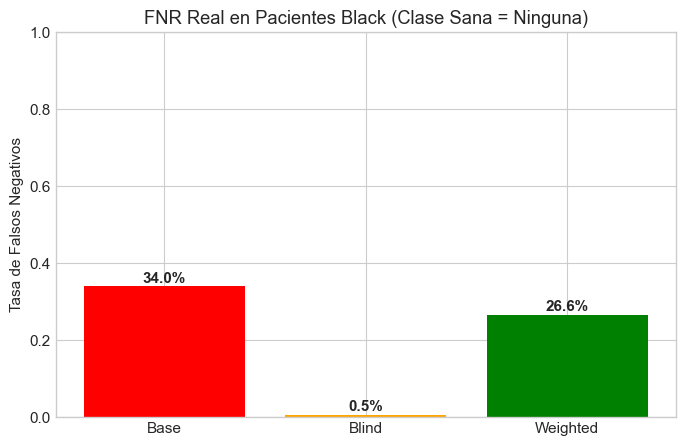

CONCLUSIÓN: La hipótesis NO se cumple. Eliminando la variable etnia, el modelo Blind tiene un error de (0.5254%).


In [ ]:
# Preparo un resumen para validar la hipótesis original

def calculate_fnr_corrected(y_true, y_pred, group_mask):
    """
    Calcula FNR = FN / (FN + TP)
    Considerando que la clase 'Sana' es SAFE_CLASS_IDX.
    """
    # Filtro las persona pacientes del grupo objetivo que REALMENTE están enfermos
    # Enfermo = Cualquier clase que NO sea la sana
    idx_sick_group = (group_mask) & (y_true != SAFE_CLASS_IDX)
    
    total_sick = idx_sick_group.sum()
    
    if total_sick == 0:
        return 0.0
    
    y_true_sick = y_true[idx_sick_group]
    y_pred_sick = y_pred[idx_sick_group]
    
    # Falsos Negativos:
    # Enfermos, pero el modelo predijo la clase SANA
    fn = (y_pred_sick == SAFE_CLASS_IDX).sum()
    
    return fn / total_sick

print("RE-CALCULANDO HIPÓTESIS CON LÓGICA CORREGIDA")

# Obtengo máscaras y predicciones para el grupo Black detectado como riesgo en el capitulo anterior.
TARGET_BLACK_NAME = "black"
TARGET_BLACK_IDX = next(k for k, v in RACE_ETHNICITY.items() if v.lower() == TARGET_BLACK_NAME.lower())
mask_black = X_test['race_ethnicity_encoded'] == TARGET_BLACK_IDX

# Aseguro que las predicciones estén actualizadas y aplanadas
preds_base = FINAL_MODEL.predict(X_test).flatten()
X_test_blind = X_test.drop(columns=['race_ethnicity_encoded'])
preds_blind = cat_model_blind.predict(X_test_blind).flatten()
preds_weighted = cat_model_weighted.predict(X_test).flatten()

# Calculo FNR
fnr_base = calculate_fnr_corrected(y_test, preds_base, mask_black)
fnr_blind = calculate_fnr_corrected(y_test, preds_blind, mask_black)
fnr_weighted = calculate_fnr_corrected(y_test, preds_weighted, mask_black)

# Visualizo los resultados y genero el veredicto
print(f"FNR Base (Black): {fnr_base:.4%}")
print(f"FNR Blind (Black): {fnr_blind:.4%}")
print(f"FNR Weighted (Black): {fnr_weighted:.4%}")

# Realizo el gráfico comparativo
plt.figure(figsize=(8, 5))
plt.bar(['Base', 'Blind', 'Weighted'], [fnr_base, fnr_blind, fnr_weighted], color=['red', 'orange', 'green'])
plt.title(f'FNR Real en Pacientes Black (Clase Sana = {TARGET_SAFE_CLASS_NAME})')
plt.ylabel('Tasa de Falsos Negativos')
plt.ylim(0, 1.0)
for i, v in enumerate([fnr_base, fnr_blind, fnr_weighted]):
    plt.text(i, v + 0.01, f"{v:.1%}", ha='center', fontweight='bold')
plt.show()
plt.close()

# Interpretación
if fnr_blind > 0.1: # Si el blind sigue fallando más del 10%
    print(f"CONCLUSIÓN: La hipótesis se cumple.")
    print(f"Incluso eliminando la variable etnia, el modelo Blind tiene un error altísimo ({fnr_blind:.4%}).")
    print(f"Esto demuestra la existencia de proxies en el ECG.")
else:
    print(f"CONCLUSIÓN: La hipótesis NO se cumple. Eliminando la variable etnia, el modelo Blind tiene un error de ({fnr_blind:.4%}).")

In [93]:
# Hago un diagnóstico detallado para entender el problema original
print("DIAGNÓSTICO DE DATOS")

# Miro qué códigos de etnia existen realmente en X_test
print("Códigos de Etnia en X_test:")
counts = X_test['race_ethnicity_encoded'].value_counts()
for code, count in counts.items():
    name = RACE_ETHNICITY.get(code, "Desconocido")
    print(f"   Code {code}: {name} (n={count})")
print("")

# Hayo la distribución de la patología en ese grupo
mask_black = X_test['race_ethnicity_encoded'] == TARGET_BLACK_IDX
y_true_black = y_test[mask_black]

print(f"Análisis del Grupo {TARGET_BLACK_IDX} ({TARGET_BLACK_NAME}):")
print(f"Total pacientes: {len(y_true_black)}")
print("")

# Hago un conteo de enfermos (y != SAFE_CLASS_IDX)
patients = (y_true_black != SAFE_CLASS_IDX).sum()
print(f"Pacientes con Patología (Real): {patients}")

if patients == 0:
    print("¡ALERTA! No hay pacientes enfermos en este grupo en el Test Set.")
    print("Por eso el FNR sale 0% (0 errores / 0 casos).")
    print("Solución: Verifica si 'Sano' es realmente el código 0.")
    print("Códigos de target disponibles:", y_test.unique())
else:
    print(f"Hay casos positivos. El error de {fnr_blind:.4%} genera dudas.")


DIAGNÓSTICO DE DATOS
Códigos de Etnia en X_test:
   Code 2: hispanic (n=1413)
   Code 5: white (n=1371)
   Code 1: black (n=760)
   Code 4: unknown (n=726)
   Code 3: other (n=414)
   Code 0: asian (n=131)

Análisis del Grupo 1 (black):
Total pacientes: 760

Pacientes con Patología (Real): 571
Hay casos positivos. El error de 0.5254% genera dudas.


# Bibliografía

1. European Parliament and Council. Regulation (EU) 2024/1689 laying down harmonised rules on artificial intelligence (Artificial Intelligence Act). Official Journal of the European Union. 2024 Jul 12;L 2024/1689.

2. Bird S, Dudík M, Edgar R, Horn B, Lutz R, Milan V, et al. Fairlearn: A toolkit for assessing and improving fairness in AI. Microsoft Research. 2020. Disponible en: https://fairlearn.org/

3. Barocas S, Hardt M, Narayanan A. Fairness and Machine Learning: Limitations and Opportunities. MIT Press; 2023. Disponible en: https://fairmlbook.org/

4. Mehrabi N, Morstatter F, Saxena N, Lerman K, Galstyan A. A Survey on Bias and Fairness in Machine Learning. ACM Computing Surveys. 2021;54(6):1-35. doi:10.1145/3457607

5. Chen IY, Szolovits P, Ghassemi M. Can AI Help Reduce Disparities in General Medical and Mental Health Care? AMA Journal of Ethics. 2019;21(2):E167-179. doi:10.1001/amajethics.2019.167

6. Obermeyer Z, Powers B, Vogeli C, Mullainathan S. Dissecting racial bias in an algorithm used to manage the health of populations. Science. 2019;366(6464):447-453. doi:10.1126/science.aax2342

7. Rajkomar A, Hardt M, Howell MD, Corrado G, Chin MH. Ensuring Fairness in Machine Learning to Advance Health Equity. Annals of Internal Medicine. 2018;169(12):866-872. doi:10.7326/M18-1990

8. Prokhorenkova L, Gusev G, Vorobev A, Dorogush AV, Gulin A. CatBoost: unbiased boosting with categorical features. Advances in Neural Information Processing Systems. 2018;31:6638-6648.

9. Hardt M, Price E, Srebro N. Equality of Opportunity in Supervised Learning. Advances in Neural Information Processing Systems. 2016;29:3315-3323.

10. Verma S, Rubin J. Fairness definitions explained. In: Proceedings of the International Workshop on Software Fairness (FairWare '18). ACM; 2018. p. 1-7. doi:10.1145/3194770.3194776

11. Lundberg SM, Lee SI. A Unified Approach to Interpreting Model Predictions. Advances in Neural Information Processing Systems. 2017;30:4765-4774.

12. Ribeiro MT, Singh S, Guestrin C. "Why Should I Trust You?": Explaining the Predictions of Any Classifier. In: Proceedings of the 22nd ACM SIGKDD. 2016. p. 1135-1144. doi:10.1145/2939672.2939778

13. Mothilal RK, Sharma A, Tan C. Explaining Machine Learning Classifiers through Diverse Counterfactual Explanations. In: Proceedings of the 2020 Conference on Fairness, Accountability, and Transparency. 2020. p. 607-617. doi:10.1145/3351095.3372850